In [1]:
%matplotlib inline
import os
import glob
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.collector import Collector
from src.learning.training.generator import GenFiles
from src.learning.training.training_file_reader import TrainingFileReader
from notebooks.notebook_commons import read_shifted_numerics_and_targets, read_stored_data_with_shifted_labels, create_memorized_dataset
from src.utilities.transformer import Transformer

In [25]:
def plot_stuff(title, plot_elems, bins=None, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Count')
    
    for plot_elem in plot_elems:
        plt.hist(plot_elem['data'], bins=bins, label=plot_elem['label'], alpha=plot_elem['alpha'])

    plt.grid(axis='both')
    plt.legend(loc='best')
    plt.show()

def half_max_thresh(counts: dict):
    return int(np.mean(counts) +  (np.max(counts) - np.mean(counts)) // 2)

def double_mean_thresh(counts: dict):
    return int(2 * np.mean(counts))
    
def downsample_indexes(data_column, sample_threshold, bin_size=0.01):
    downsample_multipliers = np.ones(data_column.shape, dtype=int)
    
    bins = np.arange(-1.0, 1.0, bin_size)
    indices = np.digitize(data_column, bins)
    unique_bins, counts = np.unique(indices, return_counts=True)
    sorted_counts = np.sort(counts)
    
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = sample_threshold(counts)
    
    for unique_bin, count in count_dict.items():
        if count > threshold_count:
            indexes = np.where(indices == unique_bin)[0]
            to_del_indexes = np.random.choice(indexes, count - threshold_count, replace=False)
            
            downsample_multipliers[to_del_indexes] = 0
    
    return downsample_multipliers


def upsample_indexes(data_column, downsampling, sample_threshold, bin_size=0.01):
    upsample_multipliers = np.zeros(data_column.shape, dtype=int)
    bins = np.arange(-1.0, 1.0, bin_size)
    indices = np.digitize(data_column, bins)
    
    unique_bins, counts = np.unique(indices, return_counts=True)
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = sample_threshold(counts)
    
    for i in range(0, upsample_multipliers.shape[0]):
        count = count_dict[indices[i]]
        if count >= threshold_count:
            upsample_multipliers[i] = downsampling[i]
        else:
            upsample_multipliers[i] = int(threshold_count / count)
    
    return upsample_multipliers


# At current recording speed, 50 instances _should_ come up to about 5 seconds
def sample_recovery(gear_column, downsampling, count_to_crash=50, peek_limit=100):
    recovery_sampling = np.copy(downsampling)
    last_gear = None
    
    recovery_start = None
    recovery_end = None
    
    for index, current_gear in enumerate(gear_column):
        if last_gear is None:
            last_gear = current_gear
            continue
        
        if last_gear == 1 and current_gear == 0 and is_reversing_ahead(gear_column, index, peek_limit):
            recovery_start = index
        
        if last_gear == 0 and current_gear == 1 and is_reversing_before(gear_column, index, peek_limit):
            recovery_end = index
        
        if recovery_start is not None and recovery_end is not None:
            recovery_sampling[recovery_start:recovery_end] = 1
            
            bad_driving_start = recovery_start - count_to_crash
            if bad_driving_start >= 0:
                recovery_sampling[bad_driving_start : recovery_start] = 0
            else:
                recovery_sampling[0 : recovery_start] = 0
            
            recovery_start = None
            recovery_end = None
        
        last_gear = current_gear
    return recovery_sampling


def is_reversing_ahead(gear_column, index, peek_limit):
    end_index = index + peek_limit
    
    if end_index >= gear_column.shape[0]:
        end_index = gear_column.shape[0] - 1
        
    for i in range(index, end_index):
        if gear_column[i] == -1:
            return True
        
    return False


def is_reversing_before(gear_column, index, peek_limit):
    start_index = index - peek_limit
    
    if start_index < 0:
        start_index = 0
        
    for i in range(index, start_index, -1):
        if gear_column[i] == -1:
            return True
        
    return False


def store_sampling(new_sampling, path, filename):
    if os.path.isfile(path + filename):
        stored_sampling = np.load(path + filename, allow_pickle=True)
        full_sampling = np.concatenate((stored_sampling, new_sampling), axis=0)
    else:
        full_sampling = new_sampling
        
    np.save(path + filename, full_sampling)

In [28]:
test_gear = np.ones(250)
test_gear[60:70] = 0
test_gear[70:140] = -1
test_gear[140:150] = 0

sample = sample_recovery(test_gear, np.zeros_like(test_gear))
print(test_gear)
print(sample)

print(np.where(test_gear == 0))
print(np.where(sample == 1))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [4]:
config_manager = ConfigurationManager()
config = config_manager.config

base_path = '../../training/'

reader = TrainingFileReader(path_to_training=base_path + 'laps/')
collector = Collector()

filenames = [fn.split('.')[0] for fn in os.listdir(base_path + 'laps/') if fn.endswith('.avi')]
print(filenames)

#filenames = ['lap_1_2020_01_24', 'lap_2_2020_01_24', 'lap_9_2020_02_07', 'lap_10_2020_02_07', 
#             'lap_11_2020_02_07', 'lap_12_2020_02_10', 'lap_13_2020_02_10', 'lap_14_2020_02_10']

memory_variants = [(1, 1), (4, 1), (4, 4)]
memory_variants = [(1, 1)]

['lap_13_2020_02_10', 'lap_4_2020_01_24', 'lap_18_2020_02_18', 'lap_10_2020_02_07', 'lap_8_2020_02_07', 'lap_20_2020_02_18', 'lap_14_2020_02_10', 'lap_16_2020_02_18', 'lap_12_2020_02_10', 'lap_7_2020_01_24', 'lap_6_2020_01_24', 'lap_25_2020_02_18', 'lap_9_2020_02_07', 'lap_17_2020_02_18', 'lap_23_2020_02_18', 'lap_22_2020_02_18', 'lap_5_2020_01_24', 'lap_15_2020_02_18', 'lap_2_2020_01_24', 'lap_19_2020_02_18', 'lap_27_2020_02_18', 'lap_26_2020_02_18', 'lap_28_2020_02_18', 'lap_3_2020_01_24', 'lap_11_2020_02_07', 'lap_24_2020_02_18', 'lap_1_2020_01_24', 'lap_21_2020_02_18', 'lap_29_2020_02_18']


In [5]:
# NB this is shifted steering specific, cut half wide frames
total_diff = None

for memory in tqdm(memory_variants):
    transformer = Transformer(config, memory)
    
    len_diff = (memory[0] - 1) * memory[1]
    memory_string = 'n{}_m{}'.format(*memory)
    path = base_path + memory_string + '/'
    
    if not os.path.isdir(path):
        os.mkdir(path)
    
    old_genfiles = glob.glob(path + '*')
    for old_genfile in old_genfiles:
        os.remove(old_genfile)
    
    tqdm.write('Writing n{}_m{} files.'.format(*memory))    
    
    for filename in tqdm(filenames):
        mem_slice_frames = []
        mem_slice_numerics = []
        
        existing_count = len([fn for fn in os.listdir(path) if fn.startswith('frame_')])
        
        numerics, diffs = read_shifted_numerics_and_targets(reader, filename, collector.numeric_columns(), collector.numeric_columns())
        stored_i = 0
        
        for i, frame in reader.read_video_gen(filename + '.avi', diffs.shape[0]):
            mem_frame = transformer.session_frame_wide(frame, mem_slice_frames)
            mem_numeric = transformer.session_numeric_np(numerics[i], mem_slice_numerics)
            
            if mem_frame is None or mem_numeric is None:
                continue
            
            np.save(path + GenFiles.frame.format(memory_string, stored_i + existing_count), mem_frame)
            np.save(path + GenFiles.steer.format(memory_string, stored_i + existing_count), mem_numeric)
            np.save(path + GenFiles.steer_diff.format(memory_string, stored_i + existing_count), diffs[i])
            stored_i += 1
            
        if total_diff is None:
            total_diff = diffs[len_diff:].copy()
        else:
            total_diff = np.concatenate((total_diff, diffs[len_diff:].copy()))

        gc.collect()

    sampling = downsample_indexes(total_diff[:, 1], half_max_thresh)
    #sampling = downsample_indexes(total_diff[:, 1], double_mean_thresh)
    #sampling = upsample_indexes(total_diff[:, 1], sampling, half_max_thresh)
    #sampling = upsample_indexes(total_diff[:, 1], sampling, double_mean_thresh)
    store_sampling(sampling, path, GenFiles.steer_sampling.format(memory_string))
    
    tqdm.write('kinda done')

Writing n1_m1 files.



kinda done



In [6]:
print(len([fn for fn in os.listdir(path) if fn.startswith('frame_')]))
print(len([fn for fn in os.listdir(path) if fn.startswith('steer_n1')]))
print(len([fn for fn in os.listdir(path) if fn.startswith('steer_diff')]))
print(total_diff.shape)

214882
214882
214882
(214882, 4)


In [9]:
sampling = downsample_indexes(total_diff[:, 1], double_mean_thresh)
samp_diffs = np.repeat(total_diff, sampling, axis=0)

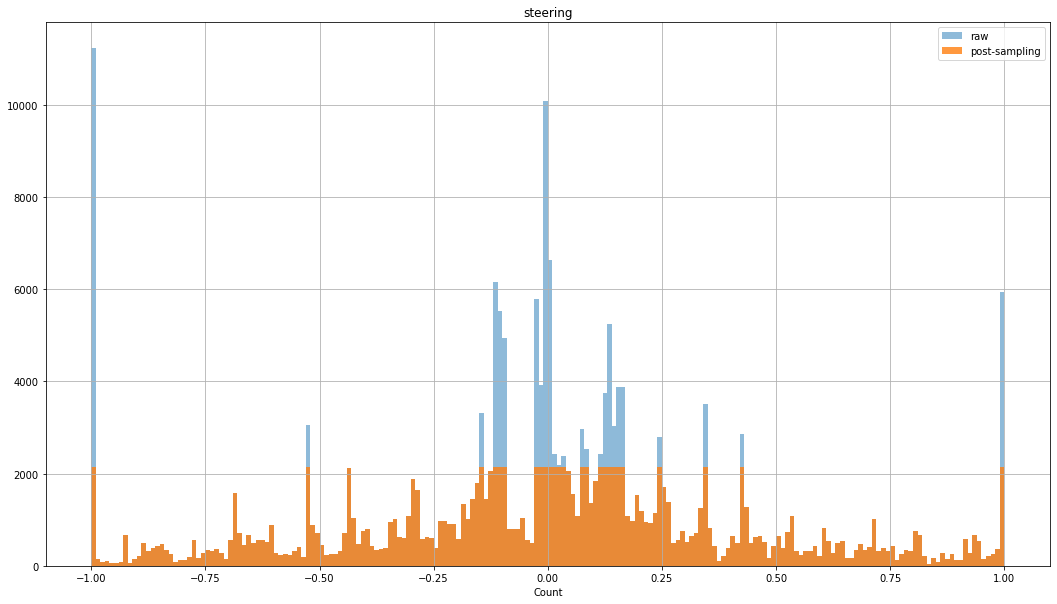

In [10]:
plot_elems = []
plot_elems.append({'data': total_diff[:, 1], 'label': 'raw', 'alpha': 0.5})
plot_elems.append({'data': samp_diffs[:, 1], 'label': 'post-sampling', 'alpha': 0.8})
bins = np.arange(-1.0, 1.01, 0.01)

plot_stuff('steering', plot_elems, bins)